# SimFin - Small Recipes Cookbook

[Original repository on GitHub](https://github.com/simfin/simfin-tutorials)

This is a collection of small recipes and examples for the [simfin](https://github.com/SimFin/simfin) Python package and [database](https://simfin.com/). You are assumed to be familiar with the basic [tutorials](https://github.com/simfin/simfin-tutorials) before reading this.

## Imports

In [1]:
# Import the main functionality from the SimFin Python API.
import simfin as sf

# Import names used for easy access to SimFin's data-columns.
from simfin.names import *

## Config

In [2]:
# SimFin data-directory.
sf.set_data_dir('~/simfin_data/')

# SimFin load API key or use free data.
sf.load_api_key(path='~/simfin_api_key.txt', default_key='free')

In [3]:
%matplotlib inline

## Load Datasets

In these examples, we will use the following datasets:

In [4]:
%%time

# Data for USA.
market = 'us'

# Load TTM Income Statements.
df_income_ttm = sf.load_income(variant='ttm', market=market)

# Load TTM Cash-Flow Statements.
df_cashflow_ttm = sf.load_cashflow(variant='ttm', market=market)

Dataset "us-income-ttm" on disk (0 days old).
- Loading from disk ... Done!
Dataset "us-cashflow-ttm" on disk (0 days old).
- Loading from disk ... Done!
CPU times: user 786 ms, sys: 63.2 ms, total: 849 ms
Wall time: 847 ms


In [5]:
# Use TTM datasets by default.
df_income = df_income_ttm
df_cashflow = df_cashflow_ttm

## EBITDA

EBITDA (Earnings Before Interest, Taxes, Depreciation and Amortization) commonly has two different definitions, this is the first:

$$
EBITDA_1 = Net\ Income + Interest + Taxes + Depreciation + Amortization
$$

The following shows how to calculate this EBITDA formula using simfin data from two datasets: Income Statements and Cash-Flow Statements.

Note that Interest Expense and Income Tax are negated in order to add them back to the Net Income, because those data-columns have negative values in the Income Statement.

Also note that we use `fillna(0)` in case some values are NaN (Not-a-Number), which would give an overall result of NaN.

In [6]:
df_ebitda1 = df_income[NET_INCOME].fillna(0) \
           - df_income[INTEREST_EXP_NET].fillna(0) \
           - df_income[INCOME_TAX].fillna(0) \
           + df_cashflow[DEPR_AMOR].fillna(0)

This is the other definition of EBITDA:

$$
EBITDA_2 = Operating\ Income + Depreciation + Amortization
$$

The results of using formula 1 and 2 are not always identical, because the Operating Income is not always identical to Net Income + Interest + Taxes, as explained [here](https://www.investopedia.com/ask/answers/012015/what-difference-between-ebit-and-operating-income.asp) and shown in the statistics below.

This is how to calculate EBITDA using the second formula with simfin data:

In [7]:
df_ebitda2 = df_income[OPERATING_INCOME].fillna(0) \
           + df_cashflow[DEPR_AMOR].fillna(0)

We can print the results of the two EBITDA calculations for ticker MSFT (Microsoft), which are clearly not identical:

In [8]:
df_ebitda1.loc['MSFT'].dropna().head()

Report Date
2004-03-31    1.101900e+10
2004-06-30    1.338200e+10
2004-09-30    1.310900e+10
2004-12-31    1.577400e+10
2005-03-31    1.735300e+10
dtype: float64

In [9]:
df_ebitda2.loc['MSFT'].head()

Report Date
2004-03-31    7.754000e+09
2004-06-30    1.022000e+10
2004-09-30    1.042100e+10
2004-12-31    1.350300e+10
2005-03-31    1.558700e+10
dtype: float64

It is only for a small fraction of the financial reports that these two EBITDA formulas give identical results:

In [10]:
(df_ebitda1 == df_ebitda2).sum() / len(df_ebitda1)

0.06335720012941524

We can also plot a histogram showing the ratio between the two EBITDA formulas:

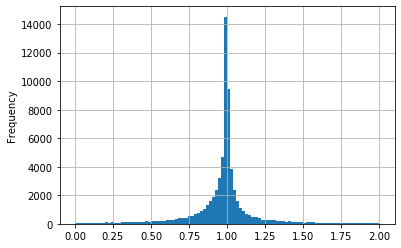

In [11]:
# Calculate ratio between the two EBITDA formulas.
df_ratio = (df_ebitda1 / df_ebitda2)

# There are some extreme outliers, so this boolean mask tells
# us which rows have an EBITDA ratio between 0 and 2.
mask = df_ratio.between(left=0, right=2)

# Plot histogram with the ratios between the two EBITDA formulas.
df_ratio[mask].plot(kind='hist', bins=100, grid=True)

### EBITDA - SimFin Function

The simfin package provides a function `sf.ebitda` for calculating the EBITDA where you can switch betwen the two EBITDA formulas. If you pass the argument `formula=NET_INCOME` then it uses the first formula for the Net Income. If you pass the argument `formula=OPERATING_INCOME` or `formula=OP_INCOME` then it uses the second formula for the Operating Income.

In [12]:
df_ebitda1 = sf.ebitda(df_income=df_income,
                       df_cashflow=df_cashflow,
                       formula=NET_INCOME)

In [13]:
df_ebitda2 = sf.ebitda(df_income=df_income,
                       df_cashflow=df_cashflow,
                       formula=OP_INCOME)

We can show the results for ticker MSFT and once again see that they are clearly different for the two formulas:

In [14]:
df_ebitda1.loc['MSFT'].head()

Report Date
2004-03-31    1.101900e+10
2004-06-30    1.338200e+10
2004-09-30    1.310900e+10
2004-12-31    1.577400e+10
2005-03-31    1.735300e+10
Name: EBITDA, dtype: float64

In [15]:
df_ebitda2.loc['MSFT'].head()

Report Date
2004-03-31    7.754000e+09
2004-06-30    1.022000e+10
2004-09-30    1.042100e+10
2004-12-31    1.350300e+10
2005-03-31    1.558700e+10
Name: EBITDA, dtype: float64

## License (MIT)

This is published under the
[MIT License](https://github.com/simfin/simfin-tutorials/blob/master/LICENSE.txt)
which allows very broad use for both academic and commercial purposes.

You are very welcome to modify and use this source-code in your own project. Please keep a link to the [original repository](https://github.com/simfin/simfin-tutorials).
